Thinking of APR. Are we doing the dual optimization with the classification model + the pertubation added?

1. Run BPR and retrieve the model parameters + predict with fixed parameters
2. Use predictions by BPR, train an adversary, save the trained parameters of the MLPs
3. Load parameters of BPR, optimize for a perturbations with the new overall objective

    Loss BPR (with fixed params + perturbation) + Loss adversary (with fixed params + perturbation)


To Do?


1. How to compute P(g = G1)? How to retrieve $P_{adv}(i)$ and $P_{adv}(j)$. As of now it is computed as, for a batch of 512 predictions for group membership, compute % of item predicted as G1, G2,...,Gn. Find conditional prob for each item
2. Audit the formula for REO and RSP
3. Tranformation function is necessary, how can we define such transformation? i.e. cannot directly optimize embedding + $\delta$ if $\delta$ is just a fixed tensor size = embedding dim
4. Tuning for the adversary, check case for 6-groups
5. Test on more extensive dataset
6. Summarize pipeline
7. Check the popularity of REO, RSP. Is this fairness definition widely used?
    - https://github.com/sisinflab/The-Idiosyncratic-Effects-of-Adversarial-Training/tree/main/src/evaluation recsys
    - https://www.semanticscholar.org/reader/f2c12f705aea19ab5e129f72ae9030375f06602f www
    - https://www.semanticscholar.org/reader/1459f5a33ae88d4c26594d867201635651c1dd72 recsys
    - https://oar.a-star.edu.sg/storage/8/8d1z0edy00/lzz-tois-fairness.pdf  TOIS
    - https://www.semanticscholar.org/reader/9eb96c7554d4dac063b47443f38866adbf90b829 recsys
    - https://arxiv.org/pdf/2203.01155.pdf UMAP
8. Will the universal perturbation work for recsys? do we have to fine-tune, add complexity to the perturbation

In [43]:
#import relevant library

import math
import os
import random
import pickle
import argparse
from collections import deque
import time
import utility
import tqdm
import copy
from operator import itemgetter
from datetime import timedelta
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
# from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader
# from torchvision import transforms
from torch.utils.data import IterableDataset, DataLoader, get_worker_info
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split



In [44]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [45]:
## time the process
def get_time_dif(start_time):
    """get the running time"""
    end_time = time.time()
    time_dif = end_time - start_time
    return timedelta(seconds=int(round(time_dif)))


## set up the u,i,j triplet for BPR framework
class GetTriplePair(IterableDataset):
    # for ml-1m we load in 3760 item 6040 user and 994169 train pair
    def __init__(self, item_size, user_list, pair, shuffle, num_epochs):
        self.item_size = item_size
        self.user_list = user_list
        self.pair = pair
        self.shuffle = shuffle
        self.num_epochs = num_epochs

    def __iter__(self):
        self.example_size = self.num_epochs * len(self.pair)
        self.example_index_queue = deque([])
        self.seed = 0
        self.start_list_index = None
        self.num_workers = 1
        self.index = 0
        return self

    def __next__(self):
        if self.index >= self.example_size:
            raise StopIteration
        # If `example_index_queue` is used up, replenish this list.
        while len(self.example_index_queue) == 0:
            index_list = list(range(len(self.pair)))
            if self.shuffle:
                random.Random(self.seed).shuffle(index_list)
                self.seed += 1
            if self.start_list_index is not None:
                index_list = index_list[self.start_list_index::self.num_workers]

                # Calculate next start index
                self.start_list_index = (self.start_list_index + (self.num_workers - (len(self.pair) % self.num_workers))) % self.num_workers
            self.example_index_queue.extend(index_list)
        result = self._example(self.example_index_queue.popleft())
        self.index += self.num_workers
        return result

    def _example(self, idx):
        # in a train pair, format = (u,i), j = a random item which does not exist in user u's list of items
        u = self.pair[idx][0]
        i = self.pair[idx][1]
        j = np.random.randint(self.item_size)
        while j in self.user_list[u]:
            j = np.random.randint(self.item_size)
        return u, i, j

## chunk to define matrix factorization part
class MF(nn.Module):
    def __init__(self, user_size, item_size, dim, reg, reg_adv, eps):
        super().__init__()
        ##init the embedding for U and I
        self.W = nn.Parameter(torch.empty(user_size, dim))  # User embedding
        self.H = nn.Parameter(torch.empty(item_size, dim))  # Item embedding
        nn.init.xavier_normal_(self.W.data)
        nn.init.xavier_normal_(self.H.data)
        self.reg = reg
        self.user_size = user_size
        self.item_size = item_size
        self.dim = dim
        self.reg_adv = reg_adv
        self.eps = eps
        self.update_u = None
        self.update_i = None
        self.update_j = None

## forward cal
    def forward(self, u, i, j, epoch):
        """Return loss value.

        Args:
            u(torch.LongTensor): tensor stored user indexes. [batch_size,]
            i(torch.LongTensor): tensor stored item indexes which is prefered by user. [batch_size,]
            j(torch.LongTensor): tensor stored item indexes which is not prefered by user. [batch_size,]
            epoch

        Returns:
            torch.FloatTensor
        """
        ##u,i,j respectively, each is a vector of dim embedding (default = 64)
        u = self.W[u, :]
        i = self.H[i, :]
        j = self.H[j, :]

        ## Enables this Tensor to have their grad populated during backward(), convert any non-leaf tensor into a leaf tensor,
        ##https://stackoverflow.com/questions/73698041/how-retain-grad-in-pytorch-works-i-found-its-position-changes-the-grad-result
        u.retain_grad()
        u_clone = u.data.clone()
        i.retain_grad()
        i_clone = i.data.clone()
        j.retain_grad()
        j_clone = j.data.clone()

        ## mf, dot product of user with pos/neg item
        x_ui = torch.mul(u, i).sum(dim=1)
        x_uj = torch.mul(u, j).sum(dim=1)


        #similar to clip value, find diff between ui and uj
        x_uij =torch.clamp(x_ui - x_uj,min=-80.0,max=1e8)
        #logsigmoid this is equivalent to equation 1 in the paper (classic loss of bpr)
        log_prob = F.logsigmoid(x_uij).sum()
        # regularization = lambda * l2 norm of u, i, j
        regularization = self.reg * (u.norm(dim=1).pow(2).sum() + i.norm(dim=1).pow(2).sum() + j.norm(dim=1).pow(2).sum())

        ## original bpr loss,
        loss = -log_prob + regularization

        loss.backward()
        return loss
        # add adv training after a certain number of epochs, here is the part which we add hypernet module
        if epoch not in range(args.epochs, args.adv_epoch + args.epochs):
            """Normal training"""
            loss.backward()
            return loss

        else:
            """Adversarial training:
                    1.Backward to get grads
                    2.Construct adversarial perturbation
                    3.Add adversarial perturbation to embeddings
                    4.Calculate APR loss
            """
            # Backward to get grads
            # this would be the part we change in defining delta, delta = HPN (phi)

            # should we calculate based on gradient of the adv_loss instead of the loss function?, originally, computed based on loss function
            loss.backward(retain_graph=True) ## need to retain graph here so as to we can backprop the adv_loss
            ##recheck this
            grad_u = u.grad
            grad_i = i.grad
            grad_j = j.grad

            # Construct adversarial perturbation based on gradient of loss function, and normalize it with epsilon * norm
            if grad_u is not None:
                delta_u = nn.functional.normalize(grad_u, p=2, dim=1, eps=self.eps)
            else:
                delta_u = torch.rand(u.size())
            if grad_i is not None:
                delta_i = nn.functional.normalize(grad_i, p=2, dim=1, eps=self.eps)
            else:
                delta_i = torch.rand(i.size())
            if grad_j is not None:
                delta_j = nn.functional.normalize(grad_j, p=2, dim=1, eps=self.eps)
            else:
                delta_j = torch.rand(j.size())

            # Add adversarial perturbation to embeddings, now we have q+delta, p+delta
            x_ui_adv = torch.mul(u + delta_u, i + delta_i).sum(dim=1)
            x_uj_adv = torch.mul(u + delta_u, j + delta_j).sum(dim=1)

            # find difference between pos and neg item, then clip value
            x_uij_adv = torch.clamp(x_ui_adv - x_uj_adv,min=-80.0,max=1e8)

            # Calculate APR loss with logsigmoid
            log_prob = F.logsigmoid(x_uij_adv).sum()
            adv_loss = self.reg_adv *(-log_prob) + loss # this is adversarial loss (equation 4 in paper)
            adv_loss.backward()

            return adv_loss


In [46]:
def evaluate_k(user_emb, item_emb, train_user_list, test_user_list, klist, batch=512):
    """Compute HR and NDCG at k.

    Args:
        user_emb (torch.Tensor): embedding for user [user_num, dim]
        item_emb (torch.Tensor): embedding for item [item_num, dim]
        train_user_list (list(set)):
        test_user_list (list(set)):
        k (list(int)):
    Returns:
        (torch.Tensor, torch.Tensor) HR and NDCG at k
    """

    # Calculate max k value
    max_k = max(klist)
    result = None

    # no iteration = user_num / batch size (which is 512)
    for i in range(0, user_emb.shape[0], batch):

        # Construct mask for each batch

        #new_ones returns a Tensor of size size filled with 1

        # size of the mask vector = (min of batch or user embed) * item+embed
        mask = user_emb.new_ones([min([batch, user_emb.shape[0]-i]), item_emb.shape[0]])
        for j in range(batch):
            if i+j >= user_emb.shape[0]:
                break
            mask[j].scatter_(dim=0, index=torch.tensor(list(train_user_list[i + j])), value=torch.tensor(0.0))

        # Get current result
        cur_result = torch.mm(user_emb[i:i+min(batch, user_emb.shape[0]-i), :], item_emb.t())
        cur_result = torch.sigmoid(cur_result)
        assert not torch.any(torch.isnan(cur_result))

        # Make zero for already observed item
        cur_result = torch.mul(mask, cur_result)
        _, cur_result = torch.topk(cur_result, k=max_k, dim=1)
        result = cur_result if result is None else torch.cat((result, cur_result), dim=0)


    ## basically this chunk collects the results
    result = result.cpu()

    # Sort indice and get HR_NDCG_topk
    HRs, NDCGs = [], []
    for k in klist:
        ndcg, hr = 0, 0
        #for all user
        for i in range(user_emb.shape[0]):
            #set helps to identify unique members in a list
            test = set(test_user_list[i])
            #top k item from prediction list
            pred = set(result[i, :k].numpy().tolist())
            #if topk lies on both test and pred list
            val = len(test & pred)
            #hit ratio = %item hit
            hr += val / max([len(test), 1])
            #convert pred back to list
            pred = list(pred)
            if test_user_list[i] == []:
                continue
            else:
                x = int(test_user_list[i][0])
                ## check if x is in the prediction where x = 1st member of user list
                if pred.count(x) != 0:
                    position = pred.index(x)
                    ndcg += math.log(2) / math.log(position + 2) if position < k else 0
                else:
                    ndcg += 0                
#                 for x in test_user_list[i]:
#                     x = int(x)
#                     ## check if x is in the prediction where x = 1st member of user list
#                     if pred.count(x) != 0:
#                         position = pred.index(x)
#                         ndcg += math.log(2) / math.log(position + 2) if position < k else 0
#                     else:
#                         ndcg += 0
        NDCGs.append(ndcg / user_emb.shape[0])
        HRs.append(hr / user_emb.shape[0])
        NDCGs.append(ndcg / user_emb.shape[0])
    return HRs, NDCGs


In [47]:
with open('preprocessed/ml-1m-2.pickle', 'rb') as f:
    dataset = pickle.load(f)
    user_size, item_size = dataset['user_size'], dataset['item_size']
    train_user_list, test_user_list = dataset['train_user_list'], dataset['test_user_list']
    train_pair = dataset['train_pair']

In [48]:
# Create dataset, model, optimizer
dataset = GetTriplePair(item_size, train_user_list, train_pair, True, 1000)

# load batch of 512 item triplets
loader = DataLoader(dataset, batch_size=512)
model = MF(user_size, item_size, 64, 0, 1, 0.5)

In [49]:
optimizer = optim.Adam(model.parameters(), lr=0.00025)

# Training
start_time = time.time()
eval_best_loss = float('inf')

##zero_grad: zeroes the grad attribute of all the parameters passed to the optimizer upon construction
optimizer.zero_grad()
epoch = 0
HR_history = []
NDCG_history = []
# result_history = []
#loader has batch size of 512. In each batch there are 3 tensors of u i j accordingly
for u, i, j in loader:
    if epoch in range(1000):
        loss = model(u, i, j, epoch)

        ##  updates the value of those parameters according to the optimization strategy implemented by the specific optimizer.
        optimizer.step()
        HR_list, NDCG_list = evaluate_k(model.W.detach(),
                                        model.H.detach(),
                                        train_user_list,
                                        test_user_list,
                                        klist=[50, 100])
        if epoch % 20 == (20- 1):
            if epoch in range(1000):
                print('BPR-MF Epoch [{}/{}]'.format(epoch + 1, 1000))
            print('loss: %.4f' % loss)
            print('HR@50: %.4f, HR@100: %.4f, NDCG@50: %.4f, NDCG@100: %.4f' % (
                HR_list[0], HR_list[1], NDCG_list[0], NDCG_list[1]))
        HR_history.append(HR_list[1])
        NDCG_history.append(NDCG_list[1])
        if epoch % 100 == 0:
            if loss < eval_best_loss:
                eval_best_loss = loss
                dirname = os.path.dirname(os.path.abspath('output/bpr_manual'))
                os.makedirs(dirname, exist_ok=True)
                torch.save(model.state_dict(), 'output/bpr_manual')
                time_dif = get_time_dif(start_time)
                print("time", time_dif)
        epoch += 1
    else:
        break


time 0:00:00
BPR-MF Epoch [20/1000]
loss: 354.7618
HR@50: 0.0338, HR@100: 0.0672, NDCG@50: 0.0101, NDCG@100: 0.0101
BPR-MF Epoch [40/1000]
loss: 354.7697
HR@50: 0.0338, HR@100: 0.0672, NDCG@50: 0.0095, NDCG@100: 0.0095
BPR-MF Epoch [60/1000]
loss: 354.8006
HR@50: 0.0334, HR@100: 0.0663, NDCG@50: 0.0091, NDCG@100: 0.0091
BPR-MF Epoch [80/1000]
loss: 354.8113
HR@50: 0.0338, HR@100: 0.0655, NDCG@50: 0.0097, NDCG@100: 0.0097
BPR-MF Epoch [100/1000]
loss: 354.7533
HR@50: 0.0343, HR@100: 0.0671, NDCG@50: 0.0098, NDCG@100: 0.0098
time 0:00:16
BPR-MF Epoch [120/1000]
loss: 354.8435
HR@50: 0.0360, HR@100: 0.0698, NDCG@50: 0.0102, NDCG@100: 0.0102
BPR-MF Epoch [140/1000]
loss: 354.4033
HR@50: 0.0388, HR@100: 0.0744, NDCG@50: 0.0105, NDCG@100: 0.0105
BPR-MF Epoch [160/1000]
loss: 354.3438
HR@50: 0.0422, HR@100: 0.0810, NDCG@50: 0.0111, NDCG@100: 0.0111
BPR-MF Epoch [180/1000]
loss: 354.1532
HR@50: 0.0498, HR@100: 0.0926, NDCG@50: 0.0139, NDCG@100: 0.0139
BPR-MF Epoch [200/1000]
loss: 352.8189
HR@

for ml-1m-2 data set with continue , epoch 1000 has
loss: 160.6638
HR@50: 0.3218, HR@100: 0.4558, NDCG@50: 0.0939, NDCG@100: 0.0939



for ml-1m-6 data set with continue , epoch 1000 has
loss: 160.6638
HR@50: 0.3218, HR@100: 0.4558, NDCG@50: 0.0939, NDCG@100: 0.0939

for ml-1m-6 data set with continue + for loop for X in test user set , epoch 1000 has
loss: 196.0934
HR@50: 0.3266, HR@100: 0.4649, NDCG@50: 0.7004, NDCG@100: 0.7004


ml-1m normal dataset
loss: 150.8645
HR@50: 0.1437, HR@100: 0.2245, NDCG@50: 0.0365, NDCG@100: 0.0365

test ml-1m normal dataset with for loop for X in test user set
loss: 181.7949
HR@50: 0.1480, HR@100: 0.2252, NDCG@50: 0.0373, NDCG@100: 0.0373

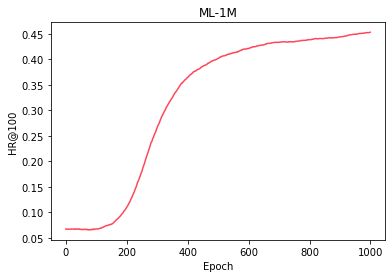

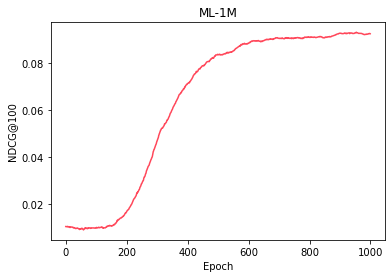

In [50]:
fig_HR = plt.figure(edgecolor='blue')
ax1 = fig_HR.add_subplot(111)
plt.ylabel('HR@100')
plt.xlabel('Epoch')
plt.title('ML-1M')
ax1.plot(range(len(HR_history)), HR_history, c=np.array([255, 71, 90]) / 255.)
plt.show()
fig_P = plt.figure(edgecolor='blue')
ax1 = fig_P.add_subplot(111)
plt.ylabel('NDCG@100')
plt.xlabel('Epoch')
plt.title('ML-1M')
ax1.plot(range(len(NDCG_history)), NDCG_history, c=np.array([255, 71, 90]) / 255.)
plt.show()

Running a saving output of BPR model

Next up = train adversary based on fixed parameters of BPR

In [51]:
train_df = pd.read_pickle(r'ml1m-6/training_df.pkl')
vali_df = pd.read_pickle(r'ml1m-6/valiing_df.pkl')
key_genre = pd.read_pickle(r'ml1m-6/key_genre.pkl')  
item_idd_genre_list = pd.read_pickle(r'ml1m-6/item_idd_genre_list.pkl')   
genre_item_vector = pd.read_pickle(r'ml1m-6/genre_item_vector.pkl')    
genre_count = pd.read_pickle(r'ml1m-6/genre_count.pkl')      
user_genre_count = pd.read_pickle(r'ml1m-6/user_genre_count.pkl') 

num_item = len(train_df['item_id'].unique())
num_user = len(train_df['user_id'].unique())
num_genre = len(key_genre)

In [52]:
genre_count

{'Sci-Fi': 271,
 'Horror': 330,
 'Crime': 193,
 'Romance': 447,
 "Children's": 248,
 'Adventure': 276}

In [53]:
item_genre_list = []
for u in range(num_item):
    gl = item_idd_genre_list[u]
    tmp = []
    for g in gl:
        if g in key_genre:
            tmp.append(g)
    item_genre_list.append(tmp)

item_genre = np.zeros((num_item, num_genre))
for i in range(num_item):
    gl = item_genre_list[i]
    for k in range(num_genre):
        if key_genre[k] in gl:
            item_genre[i, k] = 1.0

genre_count_mean_reciprocal = []

##there are six key_genre --> in the training dataset, count the number of movies for each genre
#genre_count = dictionary with number of movies for each keygrenre
for k in key_genre:
    genre_count_mean_reciprocal.append(1.0 / genre_count[k])
genre_count_mean_reciprocal = (np.array(genre_count_mean_reciprocal)).reshape((num_genre, 1))
genre_error_weight = np.dot(item_genre, genre_count_mean_reciprocal)

In [54]:
genre_count_mean_reciprocal

array([[0.00369004],
       [0.0030303 ],
       [0.00518135],
       [0.00362319],
       [0.00403226],
       [0.00223714]])

In [55]:
item_genre = torch.from_numpy(item_genre).type(torch.float)
item_genre.size()

torch.Size([1481, 6])

In [56]:
#load the results of BPR
model1 = (torch.load('output/bpr_manual'))
list(model1.items())[0][1].size(),list(model1.items())[1][1].size()




(torch.Size([6036, 64]), torch.Size([1481, 64]))

In [57]:
list(model1.items())[1][1]

tensor([[-0.2921,  0.1865,  0.0794,  ...,  0.1468, -0.0041, -0.0735],
        [-0.2600,  0.1871,  0.2491,  ..., -0.3320,  0.0178, -0.2817],
        [-0.3179, -0.3081,  0.3536,  ..., -0.4377, -0.2081, -0.3050],
        ...,
        [ 0.2057,  0.3228, -0.3675,  ...,  0.3384, -0.1572,  0.3756],
        [ 0.3807,  0.3103, -0.3507,  ...,  0.3664, -0.1035,  0.4241],
        [ 0.2991,  0.2242, -0.3828,  ...,  0.2642,  0.2661,  0.3849]])

In [58]:
Rec = np.matmul(list(model1.items())[0][1], list(model1.items())[1][1].T)
Rec.size()
# Rec[1,:].size()


torch.Size([6036, 1481])

In [60]:
import utility
utility.ranking_analysis(Rec, vali_df, train_df, key_genre,
                                                      item_genre_list, user_genre_count)

NameError: name 'u_test' is not defined

In [47]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(Rec.T, 
                                                    item_genre, 
                                                    test_size=0.2, # 20% test, 80% train
                                                    random_state=181) # make the random split reproducible

len(X_train), len(X_test), len(y_train), len(y_test)

(434, 109, 434, 109)

In [48]:
#adv, linear-relu, linear-sigmoid last layer, numlayer = 4, 512,256,128,64 hidden units 

adversary = nn.Sequential(
    nn.Linear(list(model1.items())[0][1].size()[0], 512),
#     nn.ReLU(),
    nn.Linear(512, 256),
#     nn.ReLU(),
    nn.Linear(256, 128),
#     nn.ReLU(),
    nn.Linear(128, 2),
    nn.Sigmoid()
)

In [49]:
# Create a loss function
# loss_fn = nn.BCELoss() # BCELoss = no sigmoid built-in
loss_fn = nn.BCEWithLogitsLoss() # BCEWithLogitsLoss = sigmoid built-in

# Create an optimizer
optimizer = torch.optim.Adam(params=adversary.parameters(), 
                            lr=0.000005)

In [50]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [51]:
# Calculate accuracy (a classification metric)
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / (y_true.size()[0]*y_true.size()[1])) * 100 
    return acc

In [52]:
torch.manual_seed(18)

# Set the number of epochs
epochs = 500

# Put data to target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Build training and evaluation loop
for epoch in range(epochs):
    ### Training
    adversary.train()

    # 1. Forward pass (model outputs raw logits)
    y_logits = adversary(X_train).squeeze() # squeeze to remove extra `1` dimensions, this won't work unless model and data are on same device 
    y_pred = torch.round((y_logits)) # turn logits -> pred probs -> pred labls
  
    # 2. Calculate loss/accuracy
    # loss = loss_fn(torch.sigmoid(y_logits), # Using nn.BCELoss you need torch.sigmoid()
    #                y_train) 
    loss = loss_fn(y_logits, # Using nn.BCEWithLogitsLoss works with raw logits
                   y_train) 
    acc = accuracy_fn(y_true=y_train, 
                      y_pred=y_pred) 

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    adversary.eval()
    with torch.inference_mode():
        # 1. Forward pass
        test_logits = adversary(X_test).squeeze() 
        test_pred = torch.round((test_logits))
        # 2. Caculate loss/accuracy
        test_loss = loss_fn(test_logits,
                            y_test)
        test_acc = accuracy_fn(y_true=y_test,
                               y_pred=test_pred)

    # Print out what's happening every 10 epochs
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.77921, Accuracy: 39.98% | Test loss: 0.78000, Test acc: 41.74%
Epoch: 10 | Loss: 0.76126, Accuracy: 44.82% | Test loss: 0.77477, Test acc: 44.04%
Epoch: 20 | Loss: 0.75053, Accuracy: 47.93% | Test loss: 0.77157, Test acc: 45.41%
Epoch: 30 | Loss: 0.74132, Accuracy: 50.35% | Test loss: 0.76744, Test acc: 46.79%
Epoch: 40 | Loss: 0.73305, Accuracy: 52.65% | Test loss: 0.75986, Test acc: 49.08%
Epoch: 50 | Loss: 0.71817, Accuracy: 55.07% | Test loss: 0.73932, Test acc: 52.75%
Epoch: 60 | Loss: 0.70437, Accuracy: 57.60% | Test loss: 0.72047, Test acc: 55.96%
Epoch: 70 | Loss: 0.68631, Accuracy: 59.45% | Test loss: 0.71377, Test acc: 55.96%
Epoch: 80 | Loss: 0.68162, Accuracy: 60.02% | Test loss: 0.70245, Test acc: 57.80%
Epoch: 90 | Loss: 0.68075, Accuracy: 60.25% | Test loss: 0.70243, Test acc: 57.80%
Epoch: 100 | Loss: 0.68075, Accuracy: 60.25% | Test loss: 0.70241, Test acc: 57.80%
Epoch: 110 | Loss: 0.67812, Accuracy: 60.94% | Test loss: 0.69893, Test acc: 58.72%
Epo

In [ ]:
# # prepare model and training parameters
# n_epochs = 500
# batch_size = 50
# batches_per_epoch = len(X_train) // batch_size
 
# best_acc = - np.inf   # init to negative infinity
# best_weights = None
# train_loss_hist = []
# train_acc_hist = []
# test_loss_hist = []
# test_acc_hist = []
 
# # training loop
# for epoch in range(n_epochs):
#     epoch_loss = []
#     epoch_acc = []
#     # set model in training mode and run through each batch
#     adversary.train()
#     with tqdm.trange(batches_per_epoch, unit="batch", mininterval=0) as bar:
#         bar.set_description(f"Epoch {epoch}")
#         for i in bar:
#             # take a batch
#             start = i * batch_size
#             X_batch = X_train[start:start+batch_size]
#             y_batch = y_train[start:start+batch_size]
#             # forward pass
#             y_pred = adversary(X_batch)
#             loss = loss_fn(y_pred, y_batch)
#             # backward pass
#             optimizer.zero_grad()
#             loss.backward()
#             # update weights
#             optimizer.step()
#             # compute and store metrics
#             acc = accuracy_fn(y_true=y_batch, 
#                       y_pred=y_pred)
#             epoch_loss.append(float(loss))
#             epoch_acc.append(float(acc))
#             bar.set_postfix(
#                 loss=float(loss),
#                 acc=float(acc)
#             )
#     # set model in evaluation mode and run through the test set
#     adversary.eval()
#     y_pred = adversary(X_test)
#     ce = loss_fn(y_pred, y_test)
#     acc = accuracy_fn(y_true=y_test, 
#                       y_pred=y_pred)
#     ce = float(ce)
#     acc = float(acc)
#     train_loss_hist.append(np.mean(epoch_loss))
#     train_acc_hist.append(np.mean(epoch_acc))
#     test_loss_hist.append(ce)
#     test_acc_hist.append(acc)
#     if acc > best_acc:
#         best_acc = acc
#         best_weights = copy.deepcopy(adversary.state_dict())
#     print(f"Epoch {epoch} validation: Cross-entropy={ce:.2f}, Accuracy={acc:.1f}%")
 


In [13]:
 
# Restore best model
adversary.load_state_dict(best_weights)
 
# Plot the loss and accuracy
plt.plot(train_loss_hist, label="train")
plt.plot(test_loss_hist, label="test")
plt.xlabel("epochs")
plt.ylabel("cross entropy")
plt.legend()
plt.show()
 
plt.plot(train_acc_hist, label="train")
plt.plot(test_acc_hist, label="test")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.legend()
plt.show()

NameError: name 'adversary' is not defined

In [14]:
dirname = os.path.dirname(os.path.abspath('output/adversary'))
os.makedirs(dirname, exist_ok=True)
torch.save(adversary, 'output/adversary')

NameError: name 'adversary' is not defined

Take it as it is for now, now save the parameters trained for BPR and adversary

Then train for an universal perturbation 

In [18]:
# Load
adversary = torch.load('output/adversary')
# model(X_train)
uniform_dist = torch.Tensor([0.5, 0.5])  

In [19]:
#this is for indirectly optimize the pertubation

criteria = torch.nn.MSELoss()
transform_func = torch.nn.Linear(64, 64)#.cuda()

In [30]:
class fairness_reprogramming(nn.Module):
    def __init__(self, user_emb, item_emb, Rec, reg):
        super().__init__()
        ##init the embedding for U and I
        self.user_emb = user_emb
        self.item_emb = item_emb  
        self.reg = reg
        self.perturb = nn.Parameter(torch.empty(1, 64))  # dim embedding
        nn.init.xavier_normal_(self.perturb.data)

        
## forward cal
    def forward(self, u, i, j, epoch):
        """Return loss value.
        
        Args:
            u(torch.LongTensor): tensor stored user indexes. [batch_size,]
            i(torch.LongTensor): tensor stored item indexes which is prefered by user. [batch_size,]
            j(torch.LongTensor): tensor stored item indexes which is not prefered by user. [batch_size,]
            epoch

        Returns:
            torch.FloatTensor
        """
        ##u,i,j respectively, each is a vector of dim embedding (default = 64)
#         u = self.user_emb[u, :]
#         i = self.item_emb[i, :]
#         j = self.item_emb[j, :]

        ## Enables this Tensor to have their grad populated during backward(), convert any non-leaf tensor into a leaf tensor,
        ##https://stackoverflow.com/questions/73698041/how-retain-grad-in-pytorch-works-i-found-its-position-changes-the-grad-result
#         self.perturb.retain_grad()

#       transform perturbation
        perturb = transform_func(self.perturb)
    
        transformation_loss = criteria(self.perturb,perturb)
        ## mf, dot product of user with pos/neg item
        x_ui = torch.mul(self.user_emb[u, :] , self.item_emb[i, :] + perturb).sum(dim=1)
        x_uj = torch.mul(self.user_emb[u, :] , self.item_emb[j, :] + perturb).sum(dim=1)
        

        #extract prediction for item and genres 
        
        
        ## Fix here, adversary needs to predict the recommendation for embedding + perturbation
        
        #torch.matmul(list(model1.items())[0][1], list(model1.items())[1][1][i,:].T)
        #torch.matmul(self.user_emb,(self.item_emb[i, :] + perturb).T).T[i,:]
#         i_feature = torch.matmul(self.user_emb,(self.item_emb[i, :] + perturb).T).T[i,:]
#         j_feature = torch.matmul(self.user_emb,(self.item_emb[j, :] + perturb).T).T[j,:]
        i_feature = Rec.T[i,:]
        j_feature = Rec.T[j,:]
        
#         i_genre = item_genre[i,:]
#         j_genre = item_genre[j,:]
        
        
        i.prob = adversary(i_feature).mean(axis = 0)
        j.prob = adversary(j_feature).mean(axis = 0)
        
        
        
#         1000 in a batch, group A & B
#         A 300, B 700 (    [0.3, 0.7] vs [0.5 0.5]    )
        
#         Conditional prob P(g=Ga|i) for each item
        
        #similar to clip value, find diff between ui and uj
        x_uij =torch.clamp(x_ui - x_uj,min=-80.0,max=1e8)
        #logsigmoid this is equivalent to equation 1 in the paper (classic loss of bpr)
        log_prob = F.logsigmoid(x_uij).sum()
        # regularization = lambda * l2 norm of u, i, j
        regularization = self.reg * (self.user_emb[u, :].norm(dim=1).pow(2).sum() + self.item_emb[i, :].norm(dim=1).pow(2).sum() + self.item_emb[j, :].norm(dim=1).pow(2).sum())

        ## original bpr loss,
        loss_bpr = -log_prob + regularization
#         loss_bpr.backward(retain_graph=True)
        
        
        loss_adv = F.kl_div(uniform_dist.log(), i.prob, None, None, 'sum') + F.kl_div(uniform_dist.log(), j.prob , None, None, 'sum')
        total_loss = transformation_loss + loss_bpr + loss_adv

        total_loss.backward()
        
        
        return total_loss, perturb
        

In [31]:
with open('preprocessed/ml-1m-3.pickle', 'rb') as f:
    dataset = pickle.load(f)
    user_size, item_size = dataset['user_size'], dataset['item_size']
    train_user_list, test_user_list = dataset['train_user_list'], dataset['test_user_list']
    train_pair = dataset['train_pair']

In [32]:
# Create dataset, model, optimizer
dataset = GetTriplePair(item_size, train_user_list, train_pair, True, 200)
#list(model1.items())[0][1], list(model1.items())[1][1]
# load batch of 512 item triplets
loader = DataLoader(dataset, batch_size=512)
model = fairness_reprogramming(list(model1.items())[0][1], list(model1.items())[1][1], Rec, 0)

In [33]:
for name, param in model.named_parameters():
    if param.requires_grad:
        print (name, param.data, param.data.grad)

perturb tensor([[ 1.0600e-01,  6.5238e-02, -2.6381e-01, -1.4774e-02,  2.8193e-01,
         -9.1815e-02, -8.1203e-02, -3.5143e-01, -1.3697e-01,  4.1094e-01,
          1.7212e-01, -3.4257e-01, -1.9636e-01, -2.2342e-01, -9.2034e-02,
          2.1856e-01, -3.3790e-02,  1.3517e-01, -4.1042e-02, -9.4797e-02,
         -1.2732e-01,  7.4473e-02,  1.1121e-01, -2.7012e-01,  4.4458e-01,
          7.1873e-02, -3.1197e-02, -2.9815e-01,  4.9906e-02,  1.3369e-01,
         -2.4740e-04,  1.6069e-01, -2.2408e-01, -4.9899e-02, -1.4498e-01,
          1.9026e-01,  1.9839e-01, -1.3061e-01, -8.1006e-02, -2.5560e-01,
          1.9954e-01, -8.6621e-02, -3.0126e-02, -2.2062e-01, -9.8317e-02,
         -1.9159e-01,  1.6894e-02, -3.2057e-01, -1.1384e-01,  1.1021e-01,
          1.1109e-01,  1.3879e-01, -6.7672e-02, -1.5262e-01,  5.2401e-02,
         -3.2221e-01,  5.7577e-02, -2.0666e-01,  8.4511e-02,  7.6068e-03,
         -3.7681e-01,  7.1875e-03, -1.1640e-01,  2.1399e-03]]) None


In [34]:
optimizer = optim.Adam(model.parameters(), lr=0.000025)

# Training
start_time = time.time()
eval_best_loss = float('inf')

##zero_grad: zeroes the grad attribute of all the parameters passed to the optimizer upon construction
optimizer.zero_grad()
epoch = 0
HR_history = []
NDCG_history = []
perturb_list = []
# result_history = []
#loader has batch size of 512. In each batch there are 3 tensors of u i j accordingly
for u, i, j in loader:
    if epoch in range(200):
        loss,perturb = model(u, i, j, epoch)

        ##  updates the value of those parameters according to the optimization strategy implemented by the specific optimizer.
        optimizer.step()
        HR_list, NDCG_list = evaluate_k(list(model1.items())[0][1] + perturb,
                                        list(model1.items())[1][1] + perturb,
                                        train_user_list,
                                        test_user_list,
                                        klist=[50, 100])
        if epoch % 20 == (20- 1):
            if epoch in range(1000):
                print('BPR-MF Epoch [{}/{}]'.format(epoch + 1, 1000))
            print('loss: %.4f' % loss)
            print('HR@50: %.4f, HR@100: %.4f, NDCG@50: %.4f, NDCG@100: %.4f' % (
                HR_list[0], HR_list[1], NDCG_list[0], NDCG_list[1]))
        perturb_list.append(perturb)
        HR_history.append(HR_list[1])
        NDCG_history.append(NDCG_list[1])
        if epoch % 100 == 0:
            if loss < eval_best_loss:
                eval_best_loss = loss
                dirname = os.path.dirname(os.path.abspath('output/perturbation'))
                os.makedirs(dirname, exist_ok=True)
                torch.save(model.state_dict(), 'output/perturbation')
                time_dif = get_time_dif(start_time)
                print("time", time_dif)
        epoch += 1
    else:
        break


time 0:00:01
BPR-MF Epoch [20/1000]
loss: 135.0531
HR@50: 0.4536, HR@100: 0.5974, NDCG@50: 0.1472, NDCG@100: 0.1472
BPR-MF Epoch [40/1000]
loss: 160.0160
HR@50: 0.4536, HR@100: 0.5975, NDCG@50: 0.1472, NDCG@100: 0.1472
BPR-MF Epoch [60/1000]
loss: 171.9583
HR@50: 0.4536, HR@100: 0.5976, NDCG@50: 0.1472, NDCG@100: 0.1472
BPR-MF Epoch [80/1000]
loss: 135.7449
HR@50: 0.4537, HR@100: 0.5976, NDCG@50: 0.1472, NDCG@100: 0.1472
BPR-MF Epoch [100/1000]
loss: 149.3399
HR@50: 0.4537, HR@100: 0.5976, NDCG@50: 0.1472, NDCG@100: 0.1472
time 0:00:55
BPR-MF Epoch [120/1000]
loss: 202.9521
HR@50: 0.4537, HR@100: 0.5976, NDCG@50: 0.1472, NDCG@100: 0.1472
BPR-MF Epoch [140/1000]
loss: 172.0774
HR@50: 0.4537, HR@100: 0.5976, NDCG@50: 0.1472, NDCG@100: 0.1472
BPR-MF Epoch [160/1000]
loss: 180.4559
HR@50: 0.4537, HR@100: 0.5976, NDCG@50: 0.1472, NDCG@100: 0.1472
BPR-MF Epoch [180/1000]
loss: 177.8299
HR@50: 0.4537, HR@100: 0.5976, NDCG@50: 0.1472, NDCG@100: 0.1472
BPR-MF Epoch [200/1000]
loss: 140.0361
HR@

https://stackoverflow.com/questions/66572604/optimize-input-instead-of-network-in-pytorch

In [35]:
#load the results of BPR
pertubation = (torch.load('output/perturbation'))
list(pertubation.items())[0][1].size()


torch.Size([1, 64])

In [211]:
#load the results of BPR
model1 = (torch.load('output/bpr_manual'))
list(model1.items())[0][1].size(),list(model1.items())[1][1].size()



Rec = np.matmul(list(model1.items())[0][1]+list(pertubation.items())[0][1], (list(model1.items())[1][1]+list(pertubation.items())[0][1]).T)
Rec.size()
# Rec[1,:].size()


torch.Size([5562, 543])

In [212]:
import utility
utility.ranking_analysis(Rec, vali_df, train_df, key_genre,
                                                      item_genre_list, user_genre_count)

/home/vuhoang181/Documents/code_base/APR-PyTorch/utility.py:291: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  top15 = (np.array([top15_item_idx_no_train, u_pred[top15_item_idx_no_train]])).T
/home/vuhoang181/Documents/code_base/APR-PyTorch/utility.py:291: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  top15 = (np.array([top15_item_idx_no_train, u_pred[top15_item_idx


####################################################################################################
# System-level Recall:
# 			Recall@1	Recall@5	Recall@10	Recall@15
# Sci-Fi		0.00743		0.04135		0.08665		0.13359
# Horror		0.00027		0.00214		0.00547		0.00828
# relative std		0.93061		0.90176		0.88116		0.88330
####################################################################################################
# User-level Recall:
# 			Recall@1	Recall@5	Recall@10	Recall@15
# Sci-Fi		0.00967		0.05499		0.11560		0.17443
# Horror		0.00051		0.00464		0.01163		0.01687
# relative std		0.90049		0.84452		0.81715		0.82363
####################################################################################################
# System-level top ranking probability:
# 			@1		@5		@10		@15
# Sci-Fi		0.00370		0.00764		0.00764		0.00764
# Horror		0.00035		0.00041		0.00041		0.00041
# relative std		0.82604		0.89932		0.89932		0.89932
#################################################################################

(array([0.82603744, 0.89931872, 0.89931872, 0.89931872]),
 array([0.93060609, 0.90175728, 0.88115807, 0.88330188]))

In [13]:
#before training
import utility
utility.ranking_analysis(Rec, vali_df, train_df, key_genre,
                                                      item_genre_list, user_genre_count)

/Users/vuhoang/Documents/code_base/APR-PyTorch/utility.py:291: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  top15 = (np.array([top15_item_idx_no_train, u_pred[top15_item_idx_no_train]])).T
/Users/vuhoang/Documents/code_base/APR-PyTorch/utility.py:291: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  top15 = (np.array([top15_item_idx_no_train, u_pred[top15_item_idx_no_


####################################################################################################
# System-level Recall:
# 			Recall@1	Recall@5	Recall@10	Recall@15
# Sci-Fi		0.01387		0.07008		0.13872		0.20853
# Horror		0.00013		0.00027		0.00067		0.00160
# relative std		0.98093		0.99241		0.99042		0.98475
####################################################################################################
# User-level Recall:
# 			Recall@1	Recall@5	Recall@10	Recall@15
# Sci-Fi		0.01711		0.08543		0.17070		0.25925
# Horror		0.00019		0.00038		0.00099		0.00234
# relative std		0.97804		0.99115		0.98849		0.98214
####################################################################################################
# System-level top ranking probability:
# 			@1		@5		@10		@15
# Sci-Fi		0.00357		0.00752		0.00752		0.00752
# Horror		0.00044		0.00047		0.00047		0.00047
# relative std		0.78056		0.88257		0.88257		0.88257
#################################################################################

(array([0.78055942, 0.88256852, 0.88256852, 0.88256852]),
 array([0.98093382, 0.99240851, 0.99042126, 0.98475139]))

In [17]:
torch.matmul(list(model1.items())[0][1], list(model1.items())[1][1][43,:].T)

tensor([1.9876, 3.1480, 2.5682,  ..., 1.8456, 2.9970, 1.9240])

In [18]:
for u in range(num_user):
        #for each user list all the items that he likes, mark that to -10000
        like_item = (train_df.loc[train_df['user_id'] == u, 'item_id']).tolist()
        Rec[u, like_item] = -100000.0

for u in range(num_user):  # iterate each user
    #extract item that user actually match during testing, extract the prediction
    u_test = (vali_df.loc[vali_df['user_id'] == u, 'item_id']).tolist()
    u_pred = Rec[u, :]
    
    top15_item_idx_no_train = np.argpartition(u_pred, -1 * 15)[-1 * 15:]
    top15 = (np.array([top15_item_idx_no_train, u_pred[top15_item_idx_no_train]])).T
    top15 = sorted(top15, key=itemgetter(1), reverse=True)



/tmp/ipykernel_65711/1973552975.py:12: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  top15 = (np.array([top15_item_idx_no_train, u_pred[top15_item_idx_no_train]])).T
/tmp/ipykernel_65711/1973552975.py:12: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  top15 = (np.array([top15_item_idx_no_train, u_pred[top15_item_idx_no_train]])).T


In [21]:
top15

[tensor([ 13,   4,  69,  70, 101,  65,   3,   9,  22,  28,  17,   0,  93,  37,
          25]),
 tensor([3.0920, 3.1099, 3.2114, 3.3218, 3.2073, 3.1634, 3.3581, 3.4992, 3.4403,
         3.4401, 3.4102, 3.5279, 3.6224, 3.5806, 3.6968])]

In [19]:
u_test

[38, 17, 46, 25, 0, 209]

In [23]:
if not len(u_test) == 0:
            recall_1_tmp_dict, recall_5_tmp_dict, recall_10_tmp_dict, recall_15_tmp_dict, \
            count_1_tmp_dict, count_5_tmp_dict, count_10_tmp_dict, count_15_tmp_dict, test_tmp_dict\
                = user_recall(top15, u_test, item_idd_genre_list, key_genre)
            for k in key_genre:
                count1_dict[k] += count_1_tmp_dict[k]
                count5_dict[k] += count_5_tmp_dict[k]
                count10_dict[k] += count_10_tmp_dict[k]
                count15_dict[k] += count_15_tmp_dict[k]
                test_count[k] += test_tmp_dict[k]
                if recall_1_tmp_dict[k] == -1:
                    continue
                recall1_dict[k] += recall_1_tmp_dict[k]
                recall5_dict[k] += recall_5_tmp_dict[k]
                recall10_dict[k] += recall_10_tmp_dict[k]
                recall15_dict[k] += recall_15_tmp_dict[k]
                user_count_dict[k] += 1.0

In [24]:
rank = 1
for r in top15[0]:#top 15 items sorted
# extract the genre of each topk movie
    gl = item_idd_genre_list[int(r)]
    for g in gl:
        if g in key_genre:
            #if the movie belongs to a key genre ==> add 1 to the dict
            genre_rank_count[g][rank - 1] += 1.0 #size = no. of items
            rank_count[rank - 1] += 1.0
            if rank <= 15:
                tmp_top15_dict[g] += 1.0 #no of movie in top15 for each key genre
                if rank <= 10:
                    tmp_top10_dict[g] += 1.0
                    if rank <= 5:
                        tmp_top5_dict[g] += 1.0
                        if rank <= 1:
                            tmp_top1_dict[g] += 1.0
    rank += 1 #15 rank

In [25]:
for k in key_genre:
            top1_dict[k] += tmp_top1_dict[k]
            top5_dict[k] += tmp_top5_dict[k]
            top10_dict[k] += tmp_top10_dict[k]
            top15_dict[k] += tmp_top15_dict[k]
            avg_top1_dict[k] += (1.0 * tmp_top1_dict[k] / user_genre_count[u][k])
            avg_top5_dict[k] += (1.0 * tmp_top5_dict[k] / user_genre_count[u][k])
            avg_top10_dict[k] += (1.0 * tmp_top10_dict[k] / user_genre_count[u][k])
            avg_top15_dict[k] += (1.0 * tmp_top15_dict[k] / user_genre_count[u][k])
            tmp_top1_dict[k] = 0.0
            tmp_top5_dict[k] = 0.0
            tmp_top10_dict[k] = 0.0
            tmp_top15_dict[k] = 0.0

            genre_to_be_rank[k] += user_genre_count[u][k]

In [26]:
genre_to_be_rank

{'Sci-Fi': 244.0, 'Horror': 313.0}

In [120]:
 user_genre_count[u]

{'Horror': 298, 'Sci-Fi': 153}

In [124]:
test_count

{'Sci-Fi': 17.0, 'Horror': 3.0}

In [27]:
count1_dict

{'Sci-Fi': 0.0, 'Horror': 0.0}

In [30]:
Rec = copy.copy(Rec)

count1_dict = dict()
count5_dict = dict()
count10_dict = dict()
count15_dict = dict()
test_count = dict()

recall1_dict = dict()
recall5_dict = dict()
recall10_dict = dict()
recall15_dict = dict()
user_count_dict = dict()

num_user = Rec.shape[0]
num_item = Rec.shape[1]

top1_dict = dict()
top5_dict = dict()
top10_dict = dict()
top15_dict = dict()
avg_top1_dict = dict()
avg_top5_dict = dict()
avg_top10_dict = dict()
avg_top15_dict = dict()
tmp_top1_dict = dict()
tmp_top5_dict = dict()
tmp_top10_dict = dict()
tmp_top15_dict = dict()
genre_rank_count = dict()
rank_count = np.ones(num_item) * 1e-10

genre_to_be_rank = dict()

for k in key_genre:
    genre_rank_count[k] = np.zeros(num_item)
    top1_dict[k] = 0.0
    top5_dict[k] = 0.0
    top10_dict[k] = 0.0
    top15_dict[k] = 0.0
    avg_top1_dict[k] = 0.0
    avg_top5_dict[k] = 0.0
    avg_top10_dict[k] = 0.0
    avg_top15_dict[k] = 0.0
    tmp_top1_dict[k] = 0.0
    tmp_top5_dict[k] = 0.0
    tmp_top10_dict[k] = 0.0
    tmp_top15_dict[k] = 0.0

    recall1_dict[k] = 0.0
    recall5_dict[k] = 0.0
    recall10_dict[k] = 0.0
    recall15_dict[k] = 0.0
    user_count_dict[k] = 0.0

    count1_dict[k] = 0.0
    count5_dict[k] = 0.0
    count10_dict[k] = 0.0
    count15_dict[k] = 0.0

    genre_to_be_rank[k] = 0.0
    test_count[k] = 0.0

for u in range(num_user):
    #for each user list all the items that he likes, mark that to -10000
    like_item = (train_df.loc[train_df['user_id'] == u, 'item_id']).tolist()
    Rec[u, like_item] = -100000.0

for u in range(num_user):  # iterate each user
    #extract item that user actually match during testing, extract the prediction
    u_test = (vali_df.loc[vali_df['user_id'] == u, 'item_id']).tolist()
    u_pred = Rec[u, :]


    #get top 15 items
    top15_item_idx_no_train = np.argpartition(u_pred, -1 * top4)[-1 * top4:]
    top15 = (np.array([top15_item_idx_no_train, u_pred[top15_item_idx_no_train]])).T
    top15 = sorted(top15, key=itemgetter(1), reverse=True)

    # calculate the recall for different genres
    if not len(u_test) == 0:
        recall_1_tmp_dict, recall_5_tmp_dict, recall_10_tmp_dict, recall_15_tmp_dict, \
        count_1_tmp_dict, count_5_tmp_dict, count_10_tmp_dict, count_15_tmp_dict, test_tmp_dict\
            = user_recall(top15, u_test, item_idd_genre_list, key_genre)
        for k in key_genre:
            count1_dict[k] += count_1_tmp_dict[k]
            count5_dict[k] += count_5_tmp_dict[k]
            count10_dict[k] += count_10_tmp_dict[k]
            count15_dict[k] += count_15_tmp_dict[k]
            test_count[k] += test_tmp_dict[k]
            if recall_1_tmp_dict[k] == -1:
                continue
            recall1_dict[k] += recall_1_tmp_dict[k]
            recall5_dict[k] += recall_5_tmp_dict[k]
            recall10_dict[k] += recall_10_tmp_dict[k]
            recall15_dict[k] += recall_15_tmp_dict[k]
            user_count_dict[k] += 1.0

    # calculate ranking probability
    rank = 1
    for r in top15[0]:#top 15 items sorted
    # extract the genre of each topk movie
        gl = item_idd_genre_list[int(r)]
        for g in gl:
            if g in key_genre:
                #if the movie belongs to a key genre ==> add 1 to the dict
                genre_rank_count[g][rank - 1] += 1.0 #size = no. of items
                rank_count[rank - 1] += 1.0
                if rank <= top4:
                    tmp_top15_dict[g] += 1.0 #no of movie in top15 for each key genre
                    if rank <= 10:
                        tmp_top10_dict[g] += 1.0
                        if rank <= 5:
                            tmp_top5_dict[g] += 1.0
                            if rank <= 1:
                                tmp_top1_dict[g] += 1.0
        rank += 1 #15 rank
    for k in key_genre:
        top1_dict[k] += tmp_top1_dict[k]
        top5_dict[k] += tmp_top5_dict[k]
        top10_dict[k] += tmp_top10_dict[k]
        top15_dict[k] += tmp_top15_dict[k]
        avg_top1_dict[k] += (1.0 * tmp_top1_dict[k] / user_genre_count[u][k]) #user_genre_count = no. of more in each key_genre that the user has not intereacted with in training
        avg_top5_dict[k] += (1.0 * tmp_top5_dict[k] / user_genre_count[u][k]) #no. of uninteracted items that appears in topj kust if yser
        avg_top10_dict[k] += (1.0 * tmp_top10_dict[k] / user_genre_count[u][k])
        avg_top15_dict[k] += (1.0 * tmp_top15_dict[k] / user_genre_count[u][k])
        tmp_top1_dict[k] = 0.0 #reset tmp dict
        tmp_top5_dict[k] = 0.0
        tmp_top10_dict[k] = 0.0
        tmp_top15_dict[k] = 0.0

        genre_to_be_rank[k] += user_genre_count[u][k]

# compute the average recall for different genres, and print out the results
for k in key_genre:
    #count1_dict track no. of movie in key_genre that make it to topk (in topk list predicted)
    count1_dict[k] /= test_count[k]
    count5_dict[k] /= test_count[k]
    count10_dict[k] /= test_count[k]
    count15_dict[k] /= test_count[k]
    recall1_dict[k] /= user_count_dict[k]
    recall5_dict[k] /= user_count_dict[k]
    recall10_dict[k] /= user_count_dict[k]
    recall15_dict[k] /= user_count_dict[k]

/tmp/ipykernel_65711/3143874929.py:77: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  top15 = (np.array([top15_item_idx_no_train, u_pred[top15_item_idx_no_train]])).T
/tmp/ipykernel_65711/3143874929.py:77: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  top15 = (np.array([top15_item_idx_no_train, u_pred[top15_item_idx_no_train]])).T


In [31]:
count1_dict

{'Sci-Fi': 0.013871540332654, 'Horror': 0.0001335113484646195}

In [33]:
recall1_dict

{'Sci-Fi': 0.017110188410931936, 'Horror': 0.00018996960486322188}

In [41]:
def relative_std(dictionary):
    tmp = []
    for key, value in sorted(dictionary.items(), key = lambda x: x[0]):
        tmp.append(value)
#     rstd = np.std(tmp) / (np.mean(tmp) + 1e-10)
    return np.std(tmp),np.mean(tmp)


In [42]:
relative_std(count1_dict)

(0.00686901449209469, 0.0070025258405593096)